In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
def load_data(datadir):
    count = 0
    for image in os.listdir(datadir):
        img_path = os.path.join(datadir,image)
        img_arr = cv2.imread(img_path)
        new_arr = cv2.resize(img_arr,(img_size,img_size))
        new_arr = np.array(new_arr)
        class_num = count//4
        complete_images.append([new_arr,class_num])
        count += 1

In [3]:
datadir = 'UKbench'
complete_images = []
img_size = 100
load_data(datadir)

C:\Users\harsh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


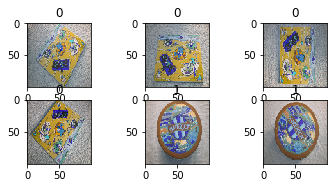

In [4]:
complete_images = np.array(complete_images)
count=0
for image,class_num in complete_images[:6]:
    plt.subplot(3,3,count+1)
    plt.imshow(image)
    plt.title(class_num)
    count += 1

In [5]:
train_dataset = []
query_dataset = []
total_images = 2000
for i in range(total_images):
    class_num = i//4
    if(i%4==0):
        query_dataset.append([complete_images[i][0],class_num])
        
    else:
        train_dataset.append([complete_images[i][0],class_num])

In [6]:
print('Number of training Images',len(train_dataset))
print('Number of training Images',len(query_dataset))
num_train_images = len(train_dataset)
num_query_images = len(query_dataset)

Number of training Images 1500
Number of training Images 500


In [7]:
inputs1 = []
for image,class_num in train_dataset:
    inputs1.append(image)

inputs1 = np.array(inputs1)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
model1_inputs = keras.Input(shape = (100,50,3),
                               name = 'model1_inputs')
model = VGG16(include_top = False, input_shape = (100,100,3))
model1 = Model(inputs = model.inputs, outputs = model.layers[-5].output)

In [9]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [10]:
preprocessed_images = preprocess_input(inputs1)
conv4_features = model1.predict(preprocessed_images)

In [11]:
print(conv4_features.shape)
inputs2 = conv4_features

(1500, 6, 6, 512)


In [12]:
def build_model():
    model_inputs = tf.keras.layers.Input(
        shape = (18,18,512),
                                          name = 'model2_inputs', dtype = np.float32)
    x = tf.keras.layers.Conv2D(512,(3,3), activation = 'relu',
                               padding = 'same',
                               name = 'new_conv1')(model_inputs)
    x = tf.keras.layers.Conv2D(512,(3,3),activation = 'relu',
                               padding = 'same',
                               name = 'new_conv2')(x)
    x = tf.keras.layers.Conv2D(512,(3,3),activation = 'relu',
                               padding = 'same',
                               name = 'new_conv3')(x)
    model_outputs = tf.keras.layers.GlobalMaxPool2D()(x)
    model2 = Model(inputs = model_inputs, outputs = model_outputs)
    model2.layers[-4].set_weights(model.layers[-4].get_weights())
    model2.layers[-3].set_weights(model.layers[-3].get_weights())
    model2.layers[-2].set_weights(model.layers[-2].get_weights())
    model2.layers[-2].activation = tf.keras.layers.PReLU(tf.initializers.constant(0.20))
    
    return model2

In [13]:
def mean_tensor(features):
    mean_features = []
    
    for i in range(num_train_images):
        actual_feature = features[i]
        actual_feature = tf.reshape(actual_feature,(1,actual_feature.shape[0]))
        similarities = tf.keras.losses.cosine_similarity(actual_feature,features)
        index = tf.argsort(similarities)
        mask = index[1:num_nearest+1]
        near_tensor = tf.gather(features,mask)
        mean = tf.math.reduce_mean(near_tensor,axis=0)
        mean_features.append(mean)
        
    mean_features = tf.convert_to_tensor(mean_features)
    return mean_features

def custom_loss(features,mean_features):
    cosine_loss = tf.keras.losses.cosine_similarity(
        features,mean_features)
    cosine_loss = tf.math.reduce_sum(cosine_loss)
    
    return cosine_loss

In [14]:
model2 = build_model()
model2.layers[-4].trainable = False
model2.layers[-3].trainable = False
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model2_inputs (InputLayer)   [(None, 18, 18, 512)]     0         
_________________________________________________________________
new_conv1 (Conv2D)           (None, 18, 18, 512)       2359808   
_________________________________________________________________
new_conv2 (Conv2D)           (None, 18, 18, 512)       2359808   
_________________________________________________________________
new_conv3 (Conv2D)           (None, 18, 18, 512)       2359808   
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
Total params: 7,079,424
Trainable params: 2,359,808
Non-trainable params: 4,719,616
_________________________________________________________________


In [15]:
features = model2(inputs2)

In [16]:
print(features.shape)
print(features[0])

(1500, 512)
tf.Tensor(
[-3.86724448e+00 -4.92823839e+00 -4.76020908e+00 -3.30720496e+00
  3.14805679e+01  1.81331043e+01 -4.38848209e+00  3.68302870e+00
 -5.60245514e+00 -4.32678431e-01 -1.18111312e+00 -7.70206928e+00
  2.30247154e+01 -6.45592356e+00 -2.09020066e+00  3.31930237e+01
 -2.96640515e+00  1.59020720e+01 -3.29168630e+00  1.66467247e+01
 -1.59239542e+00 -3.76184726e+00  2.40531015e+00 -2.84475398e+00
 -1.19855583e+00  3.37831955e+01 -4.93994284e+00 -3.12300116e-01
 -1.10271823e+00 -3.79013896e+00  5.98561049e+00 -4.34422636e+00
 -5.27143300e-01 -1.30535078e+00  2.35238590e+01 -3.92592287e+00
  1.41813498e+01  1.75650539e+01 -5.88714409e+00 -2.57613969e+00
  3.32859726e+01 -6.44199312e-01  3.91004868e+01  3.19273434e+01
 -5.01179647e+00 -2.41783786e+00  7.36698246e+00 -3.34693074e+00
 -4.70005751e+00 -2.72365332e+00  2.12616329e+01  2.08557224e+00
  2.61224918e+01  4.87080421e+01  3.21086812e+00  5.44679785e+00
 -5.17127419e+00 -3.81240010e+00  1.87631583e+00 -2.17818809e+00
 -

In [17]:
def grad_analytic(actual_feature,mean_feature):
    af = tf.reshape(actual_feature,(1,actual_feature.shape[0]))
    am = tf.reshape(mean_feature,(1,mean_feature.shape[0]))
    af_norm = tf.norm(af)
    am_norm = tf.norm(am)
    prod1 = af_norm*am_norm
    prod2 = tf.math.pow(af_norm,3)*am_norm
    grad = (am/prod1) - ((tf.matmul(af,am,transpose_b=True)*af)/prod2)
    return grad

def grad_tape(features,mean_features):
    with tf.GradientTape() as tape:
        features = model2(inputs2)
        loss = custom_loss(features,mean_features)
        grad = tape.gradient(loss,features)
    
    return grad

In [18]:
num_nearest = 1

In [19]:
mean_features = mean_tensor(features)
manual_grad = grad_analytic(features[0],mean_features[0])
auto_grad = grad_tape(features,mean_features)

In [20]:
print(manual_grad.shape)
print(auto_grad.shape)

(1, 512)
(1500, 512)


In [21]:
print(manual_grad[0][:50])

tf.Tensor(
[ 2.40739246e-06 -1.97951522e-05 -1.32955283e-05 -1.46260754e-05
 -1.27278414e-04  8.73497047e-05  2.69623670e-05  2.91758886e-04
 -8.00625639e-06 -4.23896345e-05 -1.91199797e-05 -2.29564102e-06
  2.12045372e-04 -4.01554280e-06 -3.49135553e-06  2.23479903e-04
 -1.12488615e-05 -6.70020381e-05 -2.04920252e-06 -9.50611284e-05
  1.08883796e-05  3.11172334e-06  2.04062264e-04 -3.49388938e-06
 -2.95023710e-07  2.36154883e-05 -6.29770875e-06 -1.26894302e-05
  4.68821199e-05 -3.90107380e-06  3.78434015e-05 -1.10246401e-06
  4.93842963e-05 -1.64933990e-05  4.31018998e-06  2.19553876e-05
 -5.31767691e-05 -1.43636309e-04 -2.99333224e-05  1.30645822e-06
  4.62694152e-05 -1.22777965e-05 -2.06014083e-05  1.72881177e-04
 -6.50160291e-06 -8.06131175e-06 -3.99509518e-05  1.24980288e-05
  5.54506187e-06 -3.45345106e-05], shape=(50,), dtype=float32)


In [22]:
print(auto_grad[0][:50])

tf.Tensor(
[-2.40737972e-06  1.97951704e-05  1.32955465e-05  1.46260900e-05
  1.27278341e-04 -8.73497629e-05 -2.69623579e-05 -2.91758945e-04
  8.00627822e-06  4.23896417e-05  1.91199870e-05  2.29565921e-06
 -2.12045503e-04  4.01556827e-06  3.49136099e-06 -2.23480019e-04
  1.12488688e-05  6.70020236e-05  2.04921344e-06  9.50610993e-05
 -1.08883769e-05 -3.11171243e-06 -2.04062308e-04  3.49389666e-06
  2.95027348e-07 -2.36156047e-05  6.29772330e-06  1.26894329e-05
 -4.68821236e-05  3.90108471e-06 -3.78434270e-05  1.10247856e-06
 -4.93842999e-05  1.64934027e-05 -4.31026274e-06 -2.19553804e-05
  5.31767400e-05  1.43636280e-04  2.99333478e-05 -1.30644912e-06
 -4.62695316e-05  1.22778010e-05  2.06012919e-05 -1.72881293e-04
  6.50161746e-06  8.06131902e-06  3.99509445e-05 -1.24980215e-05
 -5.54505095e-06  3.45345215e-05], shape=(50,), dtype=float32)


In [23]:
query_inputs = []
for image,class_label in query_dataset:
    query_inputs.append(image)
    
query_inputs = np.array(query_inputs)
query_inputs = preprocess_input(query_inputs)
query_features1 = model1.predict(query_inputs)

In [24]:
def top_n_score(n,query_final_features,train_features,train_final_features):
    vector = []
    for i in range(num_query_images):
        temp_score = 0
        actual_feature = query_final_features[i][0]
        actual_feature = tf.reshape(actual_feature,(1,actual_feature.shape[0]))
        similarities = tf.keras.losses.cosine_similarity(actual_feature,train_features)
        index = tf.argsort(similarities)
        for j in range(n):
            if(train_final_features[index[j]][1]==query_final_features[i][1]):
                temp_score += 1

        vector.append(temp_score) 
    
    avg_score = np.sum(vector)/len(vector)
    return avg_score

In [25]:
scores = []
n = 3

def score(query_features1,inputs2):
    query_features2 = model2(query_features1)
    train_features = model2(inputs2)
    query_final_features = []
    for i in range(num_query_images):
        query_final_features.append([query_features2[i],query_dataset[i][1]])

    train_final_features = []
    for i in range(num_train_images):
        train_final_features.append([train_features[i],train_dataset[i][1]])
        
    score = top_n_score(n,query_final_features,train_features,train_final_features)
    return score

score_before_training = score(query_features1,inputs2)

In [26]:
scores = []
scores.append(score_before_training)
print(scores)

[2.358]


In [27]:
num_epochs = 4
loss_hist = []
opt = tf.optimizers.Adam()

In [28]:
for i in range(num_epochs):
    temp_features = model2(inputs2)
    mean_features = mean_tensor(temp_features)
    with tf.GradientTape() as tape:
        tape.watch(model2.trainable_variables)
        features = model2(inputs2)
        loss = custom_loss(features,mean_features)
        loss_hist.append(loss)
        grads = tape.gradient(loss,model2.trainable_variables)
        opt.apply_gradients(zip(grads,model2.trainable_variables))
        display(loss)
        print('Epoch '+str(i+1)+' completed')
     
    temp_score = score(query_features1,inputs2)
    scores.append(temp_score)

<tf.Tensor: shape=(), dtype=float32, numpy=-1166.7727>

Epoch 1 completed


<tf.Tensor: shape=(), dtype=float32, numpy=-1367.8875>

Epoch 2 completed


<tf.Tensor: shape=(), dtype=float32, numpy=-1439.853>

Epoch 3 completed


<tf.Tensor: shape=(), dtype=float32, numpy=-1467.2266>

Epoch 4 completed


In [29]:
print(scores)

[2.358, 2.406, 2.416, 2.384, 2.382]


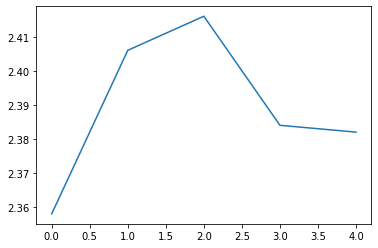

In [30]:
plt.plot(scores)